In [ ]:
# ==============================================================================
# PROJETO FINAL DE MACHINE LEARNING
# Análise de Anomalias em Transações DeFi com Aprendizagem Não Supervisionada
# Autor: Alfredo B. Santos
# ==============================================================================

# ------------------------------------------------------------------------------
# PASSO 0: Importar todas as ferramentas necessárias
# ------------------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
import warnings

# Configurações para uma melhor visualização
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", palette="viridis")
print("Ambiente de análise e bibliotecas carregados com sucesso!")


In [2]:
# ------------------------------------------------------------------------------
# PASSO 1: Carregar o Dataset Coletado Localmente
# ------------------------------------------------------------------------------
print("\n--- Passo 1: Carregando dados da Mainnet coletados pelo bot ---")

# O caminho aponta para o arquivo que nosso bot em Go está criando na pasta vizinha
file_path = '../sniper-bot/mainnet_data.jsonl'
df = pd.DataFrame()

try:
    df = pd.read_json(file_path, lines=True)
    print(f"Sucesso! Carregamos {len(df)} transações do arquivo local.")
except Exception as e:
    print(f"--- ERRO ao carregar arquivo '{file_path}': {e} ---")
    print("Verifique se o bot coletor está rodando e se o caminho do arquivo está correto.")



--- Passo 1: Carregando dados da Mainnet coletados pelo bot ---
Sucesso! Carregamos 1499 transações do arquivo local.


In [3]:
# ------------------------------------------------------------------------------
# PASSO 2: Engenharia de Features Comportamentais
# ------------------------------------------------------------------------------
if not df.empty:
    print("\n--- Passo 2: Engenharia de Features ---")
    
    # Limpeza e conversão de tipos de dados para garantir que tudo seja numérico
    for col in ['gasPrice', 'baseFeePerGas', 'value', 'gasLimit', 'nonce']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Remove linhas onde a conversão falhou ou dados essenciais estão faltando
    df.dropna(subset=['gasPrice', 'baseFeePerGas', 'value', 'gasLimit', 'inputData'], inplace=True)
    print(f"Analisando {len(df)} transações válidas após limpeza.")
    
    # FEATURE #1 (URGÊNCIA): A "gorjeta" paga para acelerar a transação
    df['priority_fee'] = df['gasPrice'] - df['baseFeePerGas']
    df['priority_fee'] = df['priority_fee'].apply(lambda x: max(x, 0))

    # FEATURE #2 (COMPLEXIDADE): O tamanho do "script" da transação
    df['input_data_size'] = df['inputData'].apply(len)

    # Selecionamos as features que descrevem o comportamento da transação
    features_df = df[['value', 'gasLimit', 'priority_fee', 'input_data_size']]
    
    print("Features criadas com sucesso!")
    print("\nResumo estatístico das nossas features:")
    display(features_df.describe())



--- Passo 2: Engenharia de Features ---
Analisando 1499 transações válidas após limpeza.
Features criadas com sucesso!

Resumo estatístico das nossas features:


,value,gasLimit,priority_fee,input_data_size
count,1.499000e+03,1.499000e+03,1.499000e+03,1499.000000
mean,1.564938e+17,3.996017e+05,7.637341e+09,509.746498
std,1.739224e+18,3.040706e+05,1.037432e+10,125.607011
min,0.000000e+00,1.000000e+05,0.000000e+00,10.000000
25%,0.000000e+00,2.282000e+05,1.145953e+09,458.000000
50%,0.000000e+00,3.337770e+05,4.255423e+09,458.000000
75%,6.046044e+16,5.000000e+05,1.054878e+10,522.000000
max,6.000000e+19,3.500000e+06,9.915902e+10,2634.000000


In [4]:
# ------------------------------------------------------------------------------
# PASSO 3: Detecção de Anomalias com Modelo Não Supervisionado
# ------------------------------------------------------------------------------
if 'features_df' in locals() and not features_df.empty:
    print("\n--- Passo 3: Treinando o Modelo de Detecção de Anomalias (Isolation Forest) ---")
    
    # Criamos o modelo. Ele irá aprender o que é "normal" e isolar o que for diferente.
    # 'contamination' é nossa estimativa de qual porcentagem dos dados são anomalias (10% é um bom chute)
    model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
    
    print("Modelo aprendendo o padrão de transações 'normais'...")
    # O modelo treina e prevê em um único passo
    predictions = model.fit_predict(features_df)
    
    # Adicionamos a previsão ao nosso DataFrame
    # -1 significa que o modelo classificou como ANOMALIA (nosso alvo de interesse)
    #  1 significa que é NORMAL
    df['anomaly'] = predictions
    
    print("\nAnálise concluída!")
    print("Distribuição das previsões (1 = Normal, -1 = Anomalia):")
    print(df['anomaly'].value_counts())
else:
    print("\nDataFrame de features não foi criado. Verifique os passos anteriores.")



--- Passo 3: Treinando o Modelo de Detecção de Anomalias (Isolation Forest) ---
Modelo aprendendo o padrão de transações 'normais'...

Análise concluída!
Distribuição das previsões (1 = Normal, -1 = Anomalia):
anomaly
 1    1349
-1     150
Name: count, dtype: int64



--- Passo 4: Visualizando e Interpretando os Resultados ---

Estatísticas das Transações ANÔMALAS (Potenciais Arbitragens):


,value,gasLimit,priority_fee
count,1.500000e+02,1.500000e+02,1.500000e+02
mean,1.090593e+18,6.686983e+05,2.150804e+10
std,5.413840e+18,6.963652e+05,2.104445e+10
min,0.000000e+00,1.250000e+05,1.848343e+07
25%,0.000000e+00,2.100000e+05,9.721330e+08
50%,3.369806e+15,5.000000e+05,1.861853e+10
75%,5.592889e+17,8.000000e+05,4.676070e+10
max,6.000000e+19,3.500000e+06,9.915902e+10


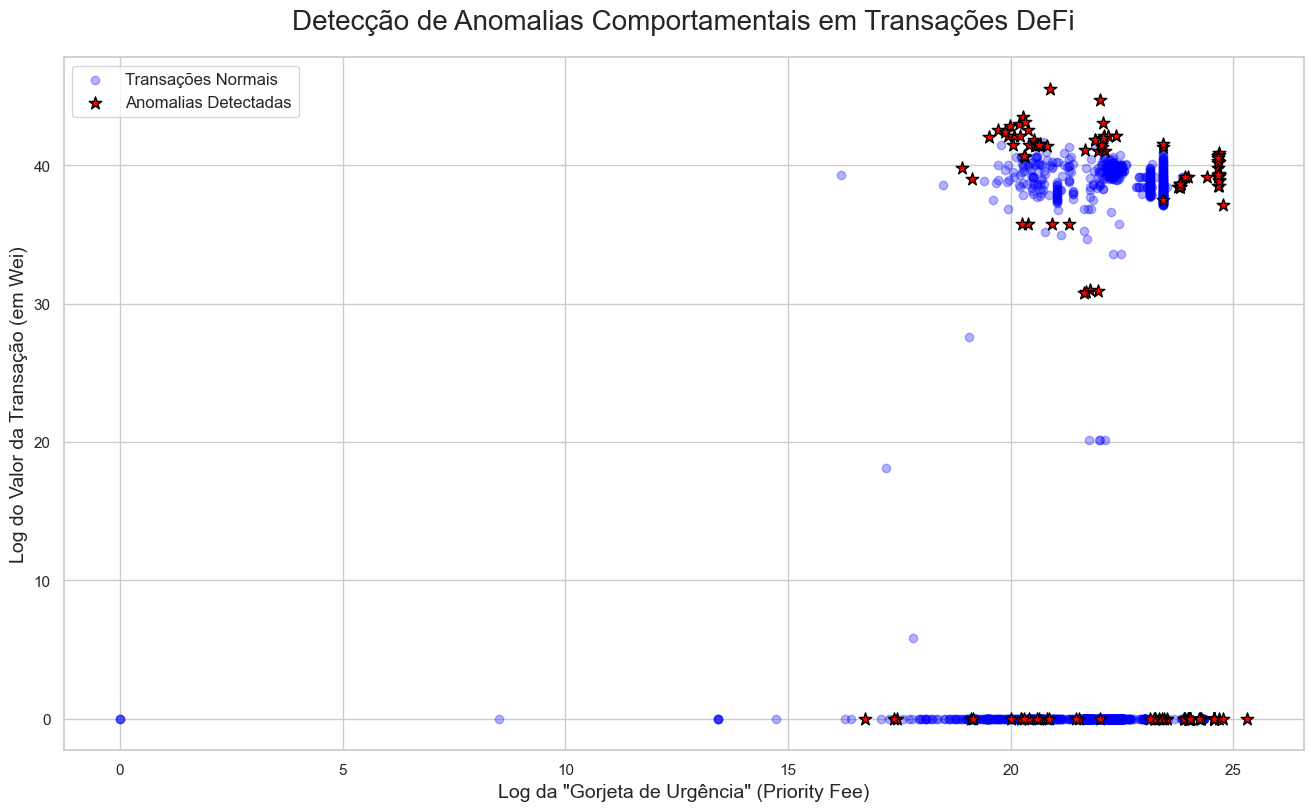

In [5]:
# ------------------------------------------------------------------------------
# PASSO 4: Visualização e Conclusão Final do Projeto
# ------------------------------------------------------------------------------
if 'df' in locals() and 'anomaly' in df.columns:
    print("\n--- Passo 4: Visualizando e Interpretando os Resultados ---")
    
    anomalies = df[df['anomaly'] == -1]
    normals = df[df['anomaly'] == 1]
    
    print("\nEstatísticas das Transações ANÔMALAS (Potenciais Arbitragens):")
    # A mediana (50%) nos dá uma ideia melhor do valor típico das anomalias
    display(anomalies[['value', 'gasLimit', 'priority_fee']].describe())
    
    # Criando o gráfico final para a sua apresentação
    plt.figure(figsize=(16, 9))
    
    # Gráfico de dispersão (scatter plot)
    # Eixo X: Log da Gorjeta (Urgência)
    # Eixo Y: Log do Valor da Transação
    plt.scatter(np.log1p(normals['priority_fee']), np.log1p(normals['value']), 
                c='blue', label='Transações Normais', alpha=0.3)
    plt.scatter(np.log1p(anomalies['priority_fee']), np.log1p(anomalies['value']), 
                c='red', label='Anomalias Detectadas', s=90, edgecolor='black', marker='*')
    
    plt.title('Detecção de Anomalias Comportamentais em Transações DeFi', fontsize=20, pad=20)
    plt.xlabel('Log da "Gorjeta de Urgência" (Priority Fee)', fontsize=14)
    plt.ylabel('Log do Valor da Transação (em Wei)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

else:
    print("\nModelo não foi treinado. Verifique se os dados foram carregados.")

In [6]:
import joblib

# Supondo que a variável 'model' contém nosso modelo RandomForest treinado
if 'model' in locals():
    # Salva o modelo treinado em um arquivo chamado 'anomaly_model.pkl'
    file_path = 'anomaly_model.pkl'
    joblib.dump(model, file_path)
    print(f"Modelo de IA salvo com sucesso no arquivo: '{file_path}'")
else:
    print("Modelo não encontrado. Execute a célula de treinamento primeiro.")

Modelo de IA salvo com sucesso no arquivo: 'anomaly_model.pkl'
